# Analysis of the impact of different types of preprocessing

In this notebook we analyze the impact of different types of image preprocessing on the performance of an object detection neural network.
In particular, for this analysis, a network incorporated in the [micromind](https://github.com/micromind-toolkit/micromind) toolkit and developed within the [E3DA](https://e3da.fbk.eu/) laboratory of the Bruno Kessler foundation was used as a detection model.
The peculiarity of this object detection model is that it requires a reduced computational resource, while maintaining robust performance.

Trained models that accept as input images accompanied by different types of preprocessing were used. In particular:
- **rgb_baseline**: accepts as input a 3-channel rgb image;
- **rgb_hsv_grayscale**: accepts as input a 7-channel image, that is 3 rgb, 3 hsv and 1 grayscale;
- **rgb_canny**: accepts as input a 4-channel image, that is 3 rgb and 1 representing the image processed with the canny algorithm for edge detection;
- **rgb_clustering**: accepts as input a 6-channel image, that is 3 original rgb and 3, always rgb, representing the image processed with the k-means clustering technique;
- **rgb_segment**: accepts as input a 4-channel image, that is 3 original rgb and 1 representing the image processed with the Yolov8n-seg segmentation model.

In [1]:
import torch

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    
print(f"Using device: {device}")

file_paths = [
    "models/rgb_baseline/save/best/state-dict.pth.tar",
    "models/rgb_hsv_grayscale/save/best/state-dict.pth.tar",
    "models/rgb_canny/save/best/state-dict.pth.tar",
    "models/rgb_clustering/save/best/state-dict.pth.tar",
    "models/rgb_segment/save/best/state-dict.pth.tar"
]

Using device: cpu


Here you can see the type of input taken by each different model.
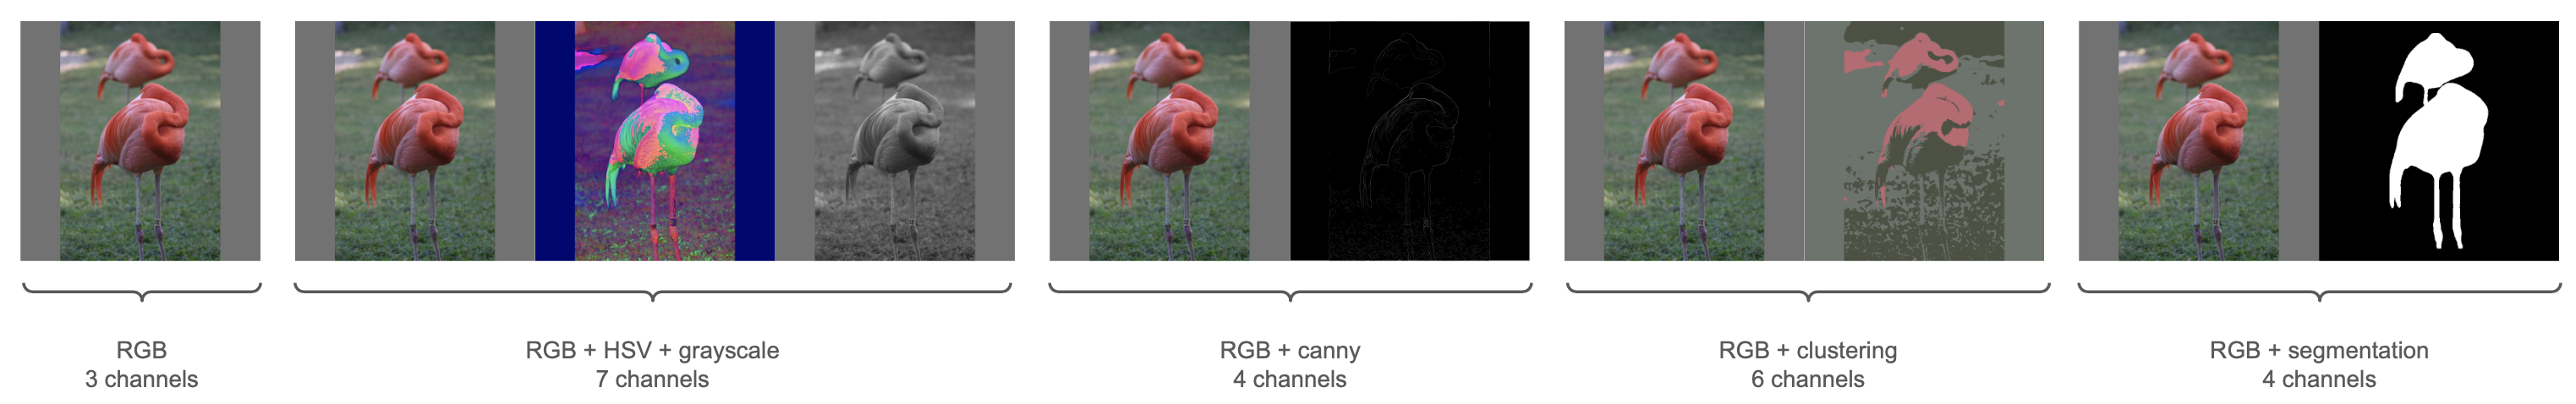

From now on the real analysis begins. In order to conduct this type of analysis you need to have the object detection models mentioned above **already trained**. Since it is a long and expensive process, these pre-trained models are provided in the `models` folder of the repository so that you can reproduce the results.
Once you have the models you can extract all the possible layers of the network and analyze their filters, in particular for how the architecture of the backbone of this network, the [PhiNets](https://arxiv.org/abs/2110.00337), was designed, we are interested in analyzing the first convolutional layer which is the one that processes the input first. This will help us understand which channels of the input representations are more influential for the purposes of detection.

In [2]:
file_path = file_paths[1]

state_dict = torch.load(file_path, map_location=device)

print("Layer names in the state dict of the model:\n")
for key in state_dict["backbone"].keys():
    print(key)

Layer names in the state dict of the model:

_layers.1._layers.0.weight
_layers.1._layers.1.weight
_layers.1._layers.2.weight
_layers.1._layers.2.bias
_layers.1._layers.2.running_mean
_layers.1._layers.2.running_var
_layers.1._layers.2.num_batches_tracked
_layers.2._layers.1.weight
_layers.2._layers.2.weight
_layers.2._layers.2.bias
_layers.2._layers.2.running_mean
_layers.2._layers.2.running_var
_layers.2._layers.2.num_batches_tracked
_layers.2._layers.4.weight
_layers.2._layers.5.weight
_layers.2._layers.5.bias
_layers.2._layers.5.running_mean
_layers.2._layers.5.running_var
_layers.2._layers.5.num_batches_tracked
_layers.3._layers.0.weight
_layers.3._layers.1.weight
_layers.3._layers.1.bias
_layers.3._layers.1.running_mean
_layers.3._layers.1.running_var
_layers.3._layers.1.num_batches_tracked
_layers.3._layers.4.weight
_layers.3._layers.5.weight
_layers.3._layers.5.bias
_layers.3._layers.5.running_mean
_layers.3._layers.5.running_var
_layers.3._layers.5.num_batches_tracked
_layers.

We can then proceed by printing all the keys of the dictionary containing the detection model and analyze the information relating to the first layer of the network, namely:
- `_layers.1._layers.0.weight`
- `_layers.1._layers.1.weight`
- `_layers.1._layers.2.weight`
- `_layers.1._layers.2.bias`
- `_layers.1._layers.2.running_mean`
- `_layers.1._layers.2.running_var`
- `_layers.1._layers.2.num_batches_tracked`

## Architecture details

To proceed with the analysis, you must first know what [depthwise separable convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728) are.

**Depthwise separable convolutions** are a variant of standard convolutions designed to improve computational efficiency by reducing the number of parameters and operations required. In a standard convolution, convolutional filters operate on all input channels simultaneously, creating a large number of operations. Depthwise separable convolutions break this process into two steps:

1. **Depthwise Convolution**: Each input channel is convolved separately with a specific filter, keeping the number of output channels the same as the input. This drastically reduces the number of operations compared to a standard convolution.

2. **Pointwise Convolution**: A convolution 1x1 is applied on each input channel to combine the information between channels, generating the desired number of output channels.

This approach is particularly advantageous in neural networks for computer vision, such as object detection models, because it allows to reduce the computational cost without significantly compromising performance.

Analyzing the weights of `_layers.1._layers.0.weight` is crucial because this tensor contains the weights associated with the depthwise convolution in the first layer of the network. Studying its magnitude provides information about how much each channel of the original input contributes to the features learned by the network, allowing to better understand the relative importance of each channel.

In [3]:
layer_keys = [
    "_layers.1._layers.0.weight",
    "_layers.1._layers.1.weight",
    "_layers.1._layers.2.weight",
    "_layers.1._layers.2.bias",
    "_layers.1._layers.2.running_mean",
    "_layers.1._layers.2.running_var",
    "_layers.1._layers.2.num_batches_tracked"
]

for key in layer_keys:
    layer = state_dict["backbone"][key]
    print("Shape of:", key, ": ", layer.shape)

Shape of: _layers.1._layers.0.weight :  torch.Size([7, 1, 3, 3])
Shape of: _layers.1._layers.1.weight :  torch.Size([56, 7, 1, 1])
Shape of: _layers.1._layers.2.weight :  torch.Size([56])
Shape of: _layers.1._layers.2.bias :  torch.Size([56])
Shape of: _layers.1._layers.2.running_mean :  torch.Size([56])
Shape of: _layers.1._layers.2.running_var :  torch.Size([56])
Shape of: _layers.1._layers.2.num_batches_tracked :  torch.Size([])


The layer we are interested in is `_layers.1._layers.0.weight`, which has size `torch.Size([7, 1, 3, 3])`. This represents the depthwise convolution weights in the first layer of the network. The size `[7, 1, 3, 3]` means that there are 7 filters (one for each input channel), each of which convolutes only a single channel (hence the `1` as the second value), with a kernel of size 3x3. This layer is crucial because it determines how each input channel is processed separately in the depthwise convolution stage, directly affecting the ability of the network to extract features from each channel.

## Results
This code is designed to analyze the importance of convolutional filters associated with input channels in a neural network, with a focus on depthwise separable convolutions. In practice, for each experiment (or model) loaded, the code extracts the weights of the depthwise convolutional layer of the first layer of the network, which are responsible for the separate convolution on each input channel.

The central idea is to calculate the "magnitude" of each filter, using the L2 norm, which provides a measure of the overall strength of the filter on a given channel. Once the magnitude for each filter is obtained, the code normalizes these values ​​to determine the relative importance of each channel compared to the others. In other words, the magnitude represents how much a filter responds to signals in its specific channel, while the relative importance indicates the percentage of contribution of that channel to the features learned by the network.

In [4]:
for experiment in file_paths:
    print("\n Experiment name:", experiment.split("/")[0])
    state_dict = torch.load(experiment, map_location=device)
    depthwise_weights = state_dict["backbone"]["_layers.1._layers.0.weight"]
    magnitudes = torch.norm(depthwise_weights, dim=[1, 2, 3], p=2)
    importance = magnitudes / magnitudes.sum()

    for i, data in enumerate(zip(magnitudes, importance)):
        print(f"Filter {i} (channel {i+1}): Magnitude = {data[0].item():.3f}, Importance = {(data[1].item())*100:.2f} %")


 Experiment name: models
Filter 0 (channel 1): Magnitude = 1.009, Importance = 33.13 %
Filter 1 (channel 2): Magnitude = 1.092, Importance = 35.87 %
Filter 2 (channel 3): Magnitude = 0.944, Importance = 31.00 %

 Experiment name: models
Filter 0 (channel 1): Magnitude = 1.151, Importance = 16.99 %
Filter 1 (channel 2): Magnitude = 1.402, Importance = 20.69 %
Filter 2 (channel 3): Magnitude = 0.946, Importance = 13.96 %
Filter 3 (channel 4): Magnitude = 0.501, Importance = 7.39 %
Filter 4 (channel 5): Magnitude = 0.403, Importance = 5.95 %
Filter 5 (channel 6): Magnitude = 1.032, Importance = 15.23 %
Filter 6 (channel 7): Magnitude = 1.340, Importance = 19.78 %

 Experiment name: models
Filter 0 (channel 1): Magnitude = 1.044, Importance = 27.97 %
Filter 1 (channel 2): Magnitude = 1.149, Importance = 30.78 %
Filter 2 (channel 3): Magnitude = 0.948, Importance = 25.40 %
Filter 3 (channel 4): Magnitude = 0.592, Importance = 15.86 %

 Experiment name: models
Filter 0 (channel 1): Magnitud

The performances, both in terms of mean average precision mAP(50-95) and loss, were obtained through the validation script present in the repo.
The results can be summarized in this table:

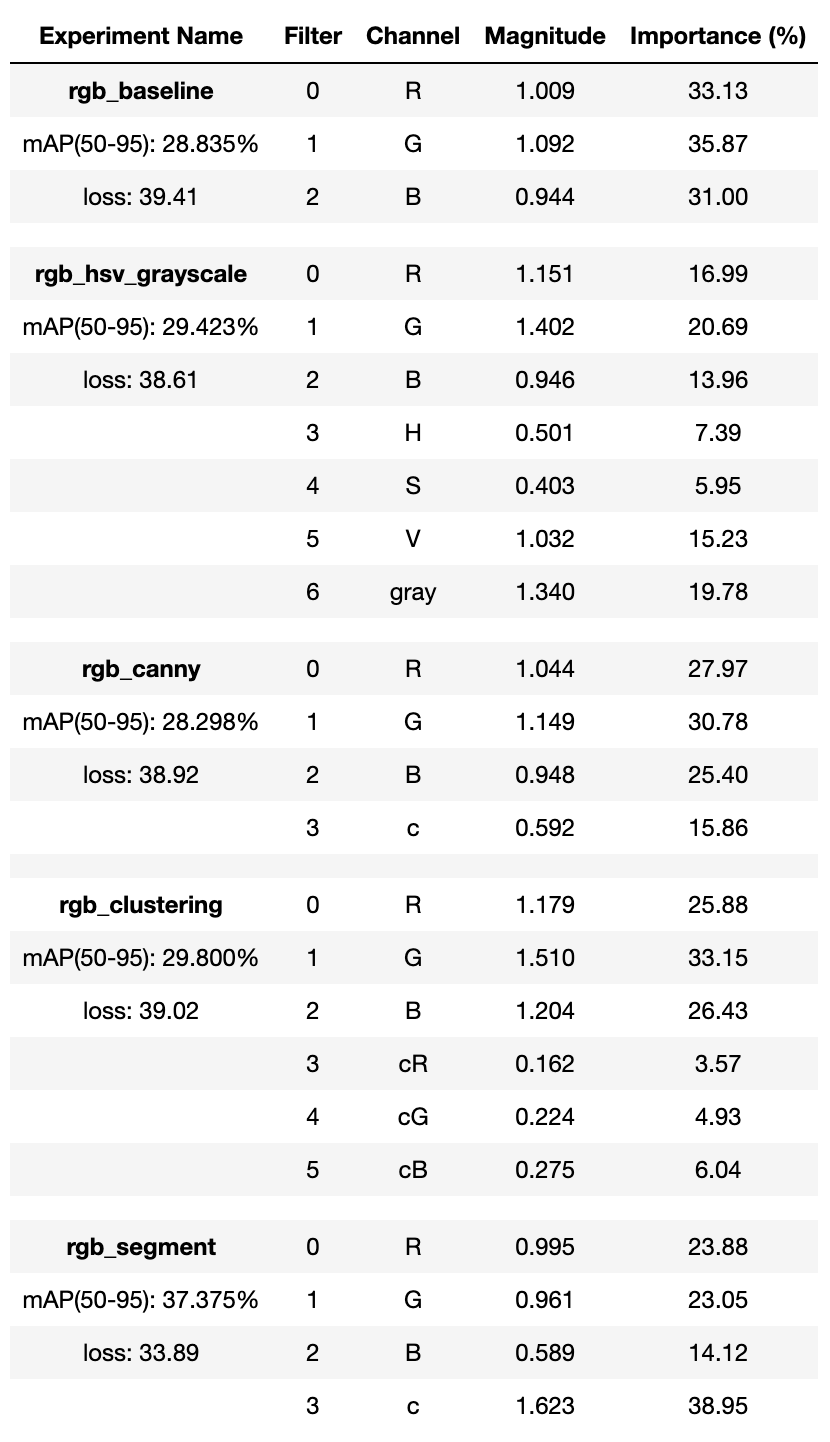

## Conclusions
The analysis of the results obtained from the different experiments reveals some key points regarding the importance of the channels and the model performance. In the RGB baseline experiment, the three channels (R, G, B) show similar filter magnitudes, with a slight predominance of the green channel (G), which could indicate a slight preference of the model for this channel. However, the mAP(50-95) of 28.835% suggests that, despite being balanced, these channels do not offer the best performance.

The experiment with the model including the HSV and grayscale channels shows a more heterogeneous distribution of magnitudes, with the green channel (G) again predominant. However, despite a better diversification of the channels, the mAP(50-95) is slightly better than the baseline, standing at 29.423%.

The Canny experiment adds a boundary channel, which shows a lower relative importance, and the mAP(50-95) result is 28.298%, lower than the other models. The clustering experiment, which introduces additional channels based on the k-means clustering technique (k=3), improves the performance with a mAP(50-95) of 29.800%, suggesting that the inclusion of clustering information can be useful.

Finally, the model integrating segmentation masks obtained with the Yolov8n-seg model clearly stands out with the best mAP(50-95) of 37.375% and a lower loss than the others. This last model is actually more of a validation test of the approach rather than a practical usable method, since the use of a segmentation model such as Yolov8n-seg would make the use of an object detection model superfluous.

### Contacts
Project developed by Matteo Beltrami.
- email: beltramimatteo01@gmail.com
- github: [@matteobeltrami](https://github.com/matteobeltrami)